# Download IAM_Words Dataset

In [174]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

#dataset has 1GB, so this might take a while 

6840.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


^C


6846.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[IAM_Words.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of IAM_Words.zip or
        IAM_Words.zip.zip, and cannot find IAM_Words.zip.ZIP, period.


6852.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6857.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: cannot create directory ‘data’: File exists


6862.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: cannot create directory ‘data/words’: File exists


6867.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
6877.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mv: cannot stat 'IAM_Words/words.txt': No such file or directory


In [175]:
!head -20 data/words.txt

6888.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [2]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from keras.layers import Dense, Conv2D, AveragePooling2D, TimeDistributed, LSTM, GlobalAveragePooling2D, AbstractRNNCell, MaxPooling2D, Reshape, Dropout
from keras.initializers import Orthogonal
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import datetime

np.random.seed(42)
tf.random.set_seed(42)

2023-01-01 12:43:19.225546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 12:43:19.578131: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-01 12:43:19.648933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-01 12:43:19.648977: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [3]:
%load_ext tensorboard

# Data Preprocessing


In [4]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
# split data set into train, validation and testset with 85:10:5 

split_idx = int(0.85 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.66666 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 81987
Total validation samples: 9645
Total test samples: 4824


# Data Pipeline

In [6]:
# path where images are stored
base_image_path = os.path.join(base_path, "words")

# images are in different subfolders. This is how we get them
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [7]:
# We need the maximum length of words to be able to use our RNN later

train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))
print("No of Characters: ", len(characters))
print("Characters: ", characters)

# Check some label samples.
print("labels examples: ",train_labels_cleaned[:10])

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

Maximum length:  21
Vocab size:  78
No of Characters:  78
Characters:  ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
labels examples:  ['sure', 'he', 'during', 'of', 'booty', 'gastronomy', 'boy', 'The', 'and', 'in']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

#StringLookUp is a Layer that maps integers to the 78 characters

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



2023-01-01 12:43:22.593977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 12:43:22.594160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-01 12:43:22.594198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-01 12:43:22.594220: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-01 12:43:22.594243: W tensorflow/c

# Image Resizing

In [9]:
# make all images the same size. 
# Adding white pixels to the sides where needed to avoid distortion

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
        
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [10]:
batch_size = 32
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 128.0 -1 
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [11]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


#  Visualize resized images

2023-01-01 12:43:23.386866: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


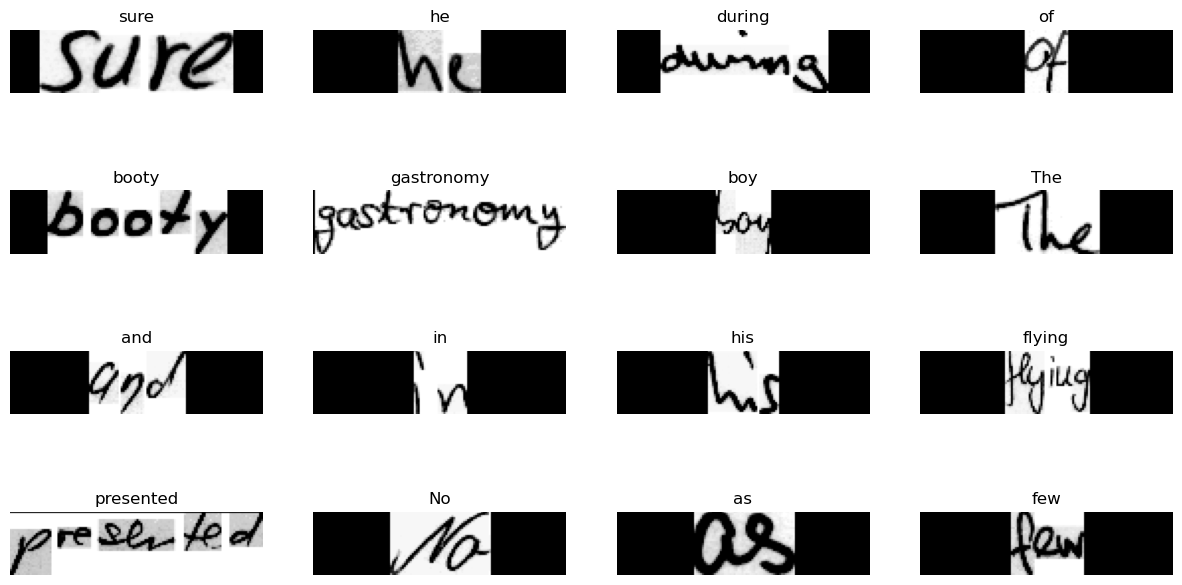

In [12]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

# Building our Model
We use a 
- CNN that can interpret letters, 
- an RNN that is applied to the letters one at a time
- CTC loss
- Adam Optimizer

In [13]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred
    

In [14]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

class EditDistance():
    def __init__(self, name) -> None:
        self.name = name
        self.results = []
 
   

    def reset_state(self):
        self.results = []

    def update_state(self, labels, predictions):
                # Get a single batch and convert its labels to sparse tensors.
        sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

        # Make predictions and convert them to sparse tensors.
        input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
        predictions_decoded = keras.backend.ctc_decode(
            predictions, input_length=input_len, greedy=True
        )[0][0][:, :max_len]
        sparse_predictions = tf.cast(
            tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
        )

        # Compute individual edit distances and average them out.
        edit_distances = tf.edit_distance(
            sparse_predictions, sparse_labels, normalize=False
        )
        self.results.append(edit_distances)

    def result(self):
        return tf.reduce_mean(self.results)
        
class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [17]:
# Overall Model

class OverallModel(tf.keras.Model):
  def __init__(self, input_shape, ctc, optimizer):
    super().__init__()

    self.input_img = keras.Input(shape=(image_width, image_height, 1), name="image")


    # input conv1 = 28x28x1
    self.conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer="he_normal", name="Conv1", input_shape=input_shape)
    # output conv1 = 28x28x24
    self.conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer="he_normal", name="Conv2")
    # output conv2 = 28x28x24
    self.pooling1 = MaxPooling2D((2,2), name="pool1")
    # output pooling1 = 14x14x24
    self.conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer="he_normal", name="Conv3")
    # output conv3 = 14x14x24
    self.conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer="he_normal", name="Conv4")
    # output conv3 = 14x14x24
    self.globalpooling = MaxPooling2D((2,2),name="pool2")
    # output globalpooling = 64


    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    self.reshape = Reshape(target_shape=new_shape, name="reshape")
    self.dense1 = Dense(64, activation="relu", name="dense1")
    self.dropout = Dropout(0.2)

    self.lstm1 = keras.layers.Bidirectional(
    keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )
    self.lstm2 = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    self.output_layer = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )
    self.ctc = ctc

    self.metrics_list = [
      #EditDistance(name= "edit distance"),      
      #tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer

  @property
  def metrics(self):
    return self.metrics_list
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, x, training = False):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.globalpooling(x)
    x = self.reshape(x)
    x = self.dense1(x)
    x = self.dropout(x)

    x = self.lstm1(x)
    x = self.lstm2(x)

    output = self.output_layer(x)
    return output

  @tf.function
  def training_step(self, images, label):

    with tf.GradientTape() as tape: 
      prediction = self(images, training = True)
      loss = self.ctc(label,prediction)


    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    #self.metrics[0].update_state(label, prediction)
    self.metrics[0].update_state(loss)  

  @tf.function
  def test_step(self, images, label):
    prediction = self(images, training = False)
    loss = self.ctc(label,prediction)
    #self.metrics[0].update_state(label, prediction)
    self.metrics[0].update_state(loss)


In [16]:
epochs = 10  # To get good results this should be at least 50.

ctc = CTCLayer()
optimizer = tf.keras.optimizers.Adam()
model = OverallModel(ctc=ctc, optimizer=optimizer, input_shape=(128,32,1))
#prediction_model = keras.models.Model(
#    model.get_layer(index=0), model.get_layer(name="dense2")
#)
#edit_distance_callback = EditDistanceCallback(prediction_model)


#prediction_model = tf.keras.models.clone_model(model)
#edit_distance_callback = EditDistanceCallback(prediction_model)


def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range (epochs):
        model.reset_metrics()
        for data in train_ds:
            images  = data["image"]
            labels  = data["label"]
            model.training_step(images, labels)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            #tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        print("Epoch: ", epoch)
        #print("Loss: ", model.metrics[1].result().numpy(), "Edit Distance: ", model.metrics[0].result().numpy(), "(Train)")
        print("Loss: ", model.metrics[0].result().numpy())
        model.reset_metrics()

        for data in test_ds:
            images  = data["image"]
            labels  = data["label"]
            model.test_step(images, labels)

        with test_summary_writer.as_default():

            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            #tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        #print("Loss: ", model.metrics[1].result().numpy(), "Edit Distance: ", model.metrics[0].result().numpy(), "(Test)")
        print("Loss: ", model.metrics[0].result().numpy())

    model.save_weights(save_path)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimizer}/words/{current_time}"
train_log_path = f"logs/words/{current_time}/train"
test_log_path = f"logs/words/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)


Epoch:  0
Loss:  0.012345679
Loss:  0.012345679
Epoch:  1
Loss:  0.012345679
Loss:  0.012345679


KeyboardInterrupt: 

In [19]:
model = OverallModel(ctc=ctc, optimizer=optimizer, input_shape=(128,32,1))
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
epochs = 10  # To get good results this should be at least 50.

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


In [ ]:
%tensorboard --logdir logs/words

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

NameError: name 'prediction_model' is not defined

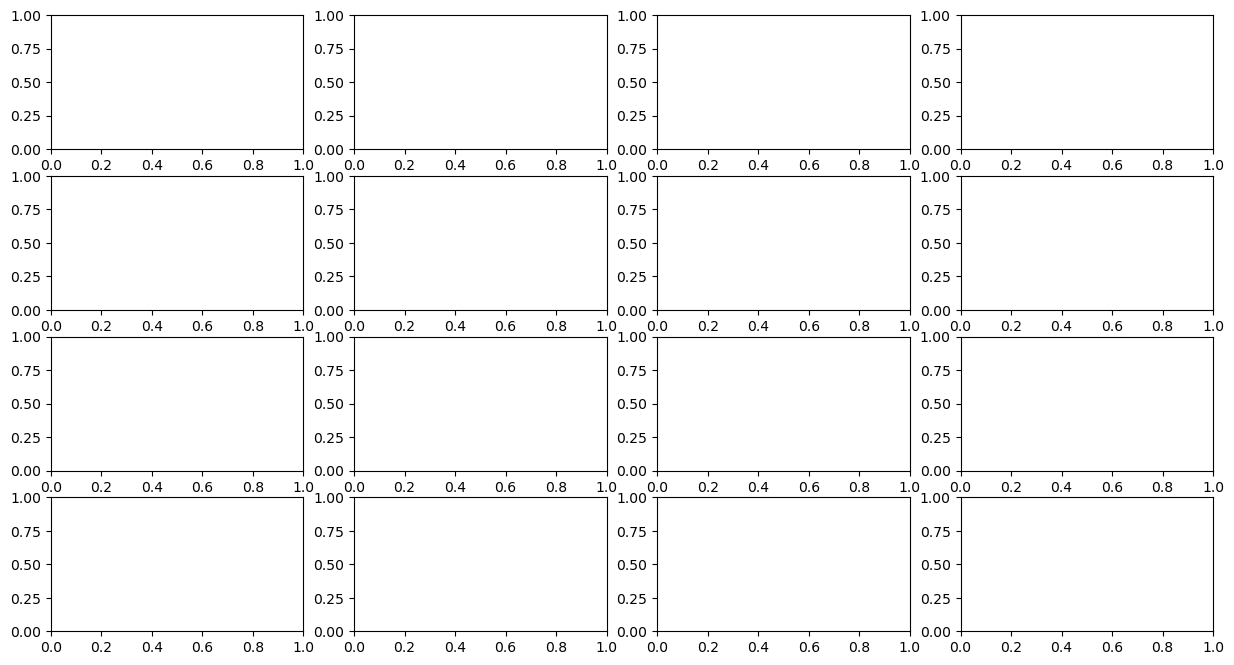

In [ ]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()